In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
from statsmodels.tsa.stattools import adfuller

## Detecting bubbles

Based on: https://itamarcaspi.github.io/psymonitor/articles/illustrationSNP.html

In [2]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3][['Date', 'CAPE']]

In [3]:
price_div = shiller_data.iloc[1224:1771]

In [4]:
price_div.index = price_div['Date']

In [5]:
price_div = price_div['CAPE']

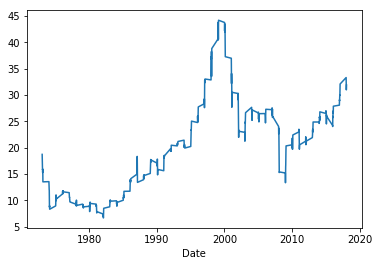

In [6]:
price_div.plot()

## Set variables

In [17]:
data = price_div
n_observations = len(data)
r0 = 0.01 + 1.8 / np.sqrt(n_observations)
min_window = int(math.floor(r0 * n_observations))
dim = n_observations - min_window + 1
lags = 2
max_lags = 6
yr = 2
control_sample_size = 12 * yr + min_window - 1
nboot = 99

In [99]:
np.random.normal(1, size=(2,3))

array([[ 0.39908047,  2.2762109 , -0.02823352],
       [ 1.85044794, -0.28708367, -0.33977032]])

In [91]:
adfuller(data, maxlag=6, regression="c", autolag='BIC', store=True, regresults=True)[-1].resols.resid

array([ -3.33269745e-01,  -4.06073963e-01,  -5.52933505e-01,
        -4.09096074e-01,   1.52162002e-01,  -6.63335952e-01,
         2.88113200e-01,   3.60192359e-01,  -1.38902828e+00,
        -9.32381787e-01,   2.37985918e-01,  -6.24311254e-01,
         4.28749582e-01,  -8.78008656e-01,  -4.41362450e-01,
        -3.82928715e-02,  -1.52033598e+00,  -3.08948501e-01,
        -1.07916677e+00,   2.46121626e-01,   1.31530157e-01,
        -7.61058496e-01,   7.10393222e-01,   6.49983756e-01,
         1.69025897e-01,  -6.93989737e-02,   5.16526285e-01,
         1.80908001e-02,  -2.00624902e-01,  -8.41892597e-01,
        -5.42375427e-02,   3.89645725e-01,  -3.13796278e-02,
        -2.61558188e-01,   9.19809140e-01,   1.53568874e-01,
        -8.82014911e-02,  -1.52728902e-03,  -2.18329448e-01,
        -4.81425510e-03,   1.61548022e-01,  -2.53371105e-01,
         1.92124617e-01,  -5.52813351e-01,  -5.02672144e-02,
         3.18512721e-01,  -2.82447266e-01,  -4.39503511e-01,
        -8.14395363e-02,

## Implementing the functions etc to detect bubbles

In [74]:
t = len(data)
# len data is 647
# min window = 47

bsadfs = np.zeros([t, 1]) # create empty column array at lenght of the data (zeros)

for r2 in range(min_window, t + 1):
    # loop over the range 47 - 647
    # create column vector of increasing lenght and fill with - 999
    rwadft = np.ones([r2 - min_window + 1, 1]) * -999
    for r1 in range(r2 - min_window + 1):
        # loop over the range 0 - 500
        # perform ADF test on data from r1 --> r2
        # insert in row
        rwadft[r1] = float(adfuller(data.iloc[r1:r2], maxlag=max_lags, autolag='BIC')[0]) # two tail 5% significant level
        
    # take max value an insert in bsadfs array
    bsadfs[r2 - 1] = max(rwadft.T[0])

# create shortened version of array
bsadf = bsadfs[min_window:t]


In [81]:
PSY(data, min_window, max_lags)

array([[ -2.76950482e+00],
       [ -2.70494583e+00],
       [ -2.60547957e+00],
       [ -2.41605590e+00],
       [ -2.27034771e+00],
       [ -2.29337915e+00],
       [ -2.32595803e+00],
       [ -2.27018936e+00],
       [ -2.25753827e+00],
       [ -2.24566129e+00],
       [ -2.18819465e+00],
       [ -2.24042018e+00],
       [ -2.24887278e+00],
       [ -1.93571147e+00],
       [ -1.85563223e+00],
       [ -1.54916580e+00],
       [ -1.71744668e+00],
       [ -1.83194529e+00],
       [ -1.74883795e+00],
       [ -1.66080183e+00],
       [ -1.43273823e+00],
       [ -1.43512351e+00],
       [ -1.36789478e+00],
       [ -1.38167461e+00],
       [ -8.68648381e-01],
       [ -9.05382523e-01],
       [ -7.31610807e-01],
       [ -7.57473460e-01],
       [ -8.15121242e-01],
       [ -6.15990336e-01],
       [ -5.08293942e-01],
       [ -5.02688787e-01],
       [ -6.67137345e-01],
       [ -6.72509539e-01],
       [ -4.29200179e-01],
       [ -3.34075826e-01],
       [ -5.21839181e-01],
 

In [80]:
def PSY(y, swindow0, adflag):
    """
    Estimate PSY's BSADF sequence of test statistics
    implements the real time bubble detection procedure of Phillips, Shi and Yu (2015a,b)
    
    param: y: np.array of the data
    param: swindow0: integer minimum window size 
    param: adflag: An integer, lag order when IC=0; maximum number of lags when IC>0 (default = 0).
    
    For every period in time calculate the max ADF statistic using a rolling window. 
    
    return: list BSADF test statistic.
    """
    t = len(y)
    
    if not swindow0: 
        swindow0 = int(math.floor(t * (0.01 + 1.8 / np.sqrt(t))))

    bsadfs = np.zeros([t, 1]) # create empty column array at lenght of the data (zeros)

    for r2 in range(swindow0, t + 1):
    # loop over the range 47 - 647
    # create column vector of increasing lenght and fill with - 999
        rwadft = np.ones([r2 - swindow0 + 1, 1]) * -999
        for r1 in range(r2 - swindow0 + 1):
            # loop over the range 0 - 500
            # perform ADF test on data from r1 --> r2
            # insert in row
            rwadft[r1] = float(adfuller(y.iloc[r1:r2], maxlag=adflag, autolag='BIC')[0]) # two tail 5% significant level
        
        # take max value an insert in bsadfs array
        bsadfs[r2 - 1] = max(rwadft.T[0])

    # create shortened version of array
    bsadf = bsadfs[swindow0:t]
    
    return bsadf

In [ ]:
def cvPSYwmboot(y, swindow0, adflag, Tb, nboot, nCores = 2):  # IC = 'BIC'
    """
    Computes a matrix of 90, 95 and 99 critical values which can be used to compare to the bsadf statistics.
    
    
    
    return: A matrix. BSADF bootstrap critical value sequence at the 90, 95 and 99 percent level.
    """